# Clustering and Comparing neighborhoods of New York and Toronto

In [230]:
import pandas as pd
import numpy as np
import requests as rq
import folium
!pip install geopy
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import json
from IPython.display import HTML
from matplotlib import pyplot as plt

print('***Success***')

***Success***


#### Loading New York neighborhood Data

In [2]:
ny_data = rq.get('https://raw.githubusercontent.com/ujoshidev/Coursera_Capstone/main/Week3/newyork_data.json').json()
#ny_data

In [3]:
ny_neigh_data = ny_data['features']
ny_neigh_data[:1]

[{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
   'type': 'Point'},
  'geometry_name': 'geom',
  'id': 'nyu_2451_34572.1',
  'properties': {'annoangle': 0.0,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661],
   'borough': 'Bronx',
   'name': 'Wakefield',
   'stacked': 1},
  'type': 'Feature'}]

#### Loading JSON data into Pandas Dataframe and creating proper structure for use

In [4]:
ny_neigh = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for n in ny_neigh_data:
    nbor = n['properties']['borough']
    nlat = n['geometry']['coordinates'][1]
    nlon = n['geometry']['coordinates'][0]
    nnei = n['properties']['name']
    
    ny_neigh = ny_neigh.append({'Borough':nbor, 'Neighborhood':nnei, 'Latitude':nlat, 'Longitude':nlon},ignore_index=True)
ny_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_neigh['Borough'].unique()),
        ny_neigh.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


However, in this dataframe, there are neighborhoods that share the same name but are located in different boroughs as shown below

In [6]:
tmp = ny_neigh['Neighborhood'].value_counts()
tmp[tmp > 1]

Bay Terrace    2
Murray Hill    2
Sunnyside      2
Chelsea        2
Name: Neighborhood, dtype: int64

In [7]:
ny_neigh[ny_neigh['Neighborhood'] == 'Chelsea']

,Borough,Neighborhood,Latitude,Longitude
116,Manhattan,Chelsea,40.744035,-74.003116
244,Staten Island,Chelsea,40.594726,-74.189560


To deal with this case, we are including borough name in the name of these neighborhoods. For example, "Chelsea" neighborhood which is located in "Staten Island" borough will be named "Chelsea, Staten Island" and the one in "Manhattan" will be named "Manhattan, Queens":

In [8]:
for i in range(ny_neigh.shape[0]):
    nyn = ny_neigh.loc[i, 'Neighborhood']
    if ny_neigh[ny_neigh['Neighborhood'] == nyn].shape[0] > 1:
        ind = ny_neigh[ny_neigh['Neighborhood'] == nyn].index.tolist()
        for j in ind:
            nyb = ny_neigh.loc[j, 'Borough']
            ny_neigh.loc[j, 'Neighborhood'] = nyn + ', ' + nyb

ny_neigh[ny_neigh['Neighborhood'].str.startswith('Chelsea')]

,Borough,Neighborhood,Latitude,Longitude
116,Manhattan,"Chelsea, Manhattan",40.744035,-74.003116
244,Staten Island,"Chelsea, Staten Island",40.594726,-74.189560


#### Using geopy Library to get the Coordinates of New York City & creating map of New York with overlayed Neighborhood

In [9]:
##Using geopy Library to get the Coordinates of New York City

address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_neigh['Latitude'], 
                                           ny_neigh['Longitude'], 
                                           ny_neigh['Borough'], 
                                           ny_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Retriving venue data for New York city using Foresquare API [v2/venues/explore]

In [11]:
# Foursquare API credentials
CLIENT_ID = 'A1VPXW0G4VZLCKIMZUOGCWBXBGIY5UP21CRGT0R4OJXJOWBQ' 
CLIENT_SECRET = 'HK051UQF5HLYE5044ZAZ3R00GBQS05DCO25UV24Y531IYBQT' 
VERSION = '20180605'

In [12]:
ny_neigh.loc[0]

Borough             Bronx
Neighborhood    Wakefield
Latitude          40.8947
Longitude        -73.8472
Name: 0, dtype: object

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = rq.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
ny_neigh['Neighborhood'].count()

306

In [15]:
nyc_venues = getNearbyVenues(names=ny_neigh['Neighborhood'],
                             latitudes=ny_neigh['Latitude'],
                             longitudes=ny_neigh['Longitude']
                            )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Compairing Number of Neighborhoods we have in our dataset with data returned by Foresquare

In [93]:
ny_neigh.shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 305)

We notice that there are 305 neighborhoods in the *nyc_venues* while we had 306 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for 1 neighborhood.

In [94]:
ny_excluded_neighborhood = set(ny_neigh['Neighborhood']).difference(nyc_venues['Neighborhood'])
ny_excluded_neighborhood

{'Port Ivory'}

In [95]:
print(nyc_venues.shape)
nyc_venues.head()

(10221, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant


#### Let's check data returned for each neighborhood

In [96]:
nyc_venues.groupby(by='Neighborhood').size()

Neighborhood
Allerton          27
Annadale          10
Arden Heights      4
Arlington          7
Arrochar          20
                ... 
Woodhaven         21
Woodlawn          27
Woodrow           19
Woodside          82
Yorkville        100
Length: 305, dtype: int64

In [97]:
# Unique categories that can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 445 uniques categories.


In [98]:
# Performing one-hot on the venue category variable

# one hot encoding
ny_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
ny_onehot['Neighborhood_'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(10221, 446)


,Neighborhood_,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
#Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood
ny_grouped = ny_onehot.groupby('Neighborhood_').mean().reset_index()
print(ny_grouped.shape)
ny_grouped.head()

(305, 446)


,Neighborhood_,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
nyc_venues[nyc_venues['Neighborhood']=='Port Ivory']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [101]:
# Let's print each neighborhood along with the top 5 most common venues.
## We will add this info in Pandas dataframe in next step
num_top_venues = 5

for hood in ny_grouped['Neighborhood_']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood_'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
            venue  freq
0   Deli / Bodega  0.11
1     Pizza Place  0.11
2  Discount Store  0.07
3     Supermarket  0.07
4        Pharmacy  0.07


----Annadale----
           venue  freq
0    Pizza Place   0.2
1   Liquor Store   0.1
2          Diner   0.1
3       Pharmacy   0.1
4  Train Station   0.1


----Arden Heights----
         venue  freq
0         Pool  0.25
1  Coffee Shop  0.25
2  Pizza Place  0.25
3     Pharmacy  0.25
4          ATM  0.00


----Arlington----
           venue  freq
0       Bus Stop  0.29
1  Deli / Bodega  0.14
2   Intersection  0.14
3    Coffee Shop  0.14
4  Grocery Store  0.14


----Arrochar----
                       venue  freq
0              Deli / Bodega  0.10
1         Italian Restaurant  0.10
2                Pizza Place  0.10
3                   Bus Stop  0.10
4  Middle Eastern Restaurant  0.05


----Arverne----
            venue  freq
0       Surf Spot  0.19
1  Sandwich Place  0.10
2   Metro Station  0.10
3        Tiki Bar  0.05
4   Bur

In [102]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:
# Creating new dataframe with top 5 venues for each neighborhood.

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood_']

for ind in np.arange(ny_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Deli / Bodega,Pizza Place,Supermarket,Discount Store,Pharmacy
1,Annadale,Pizza Place,Pharmacy,Restaurant,Liquor Store,Train Station
2,Arden Heights,Pharmacy,Coffee Shop,Pool,Pizza Place,Yoga Studio
3,Arlington,Bus Stop,Deli / Bodega,Grocery Store,Coffee Shop,Intersection
4,Arrochar,Italian Restaurant,Bus Stop,Pizza Place,Deli / Bodega,Mediterranean Restaurant


#### Clustering Neighborhoods of New York city

In [104]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [105]:
# Creating a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood

# add clustering labels
ny_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_neigh
ny_merged = ny_merged[~ny_merged['Neighborhood'].isin(ny_excluded_neighborhood)]

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(ny_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Pharmacy,Donut Shop,Caribbean Restaurant,Laundromat,Dessert Shop
1,Bronx,Co-op City,40.874294,-73.829939,0,Bus Station,Fried Chicken Joint,Restaurant,Pharmacy,Trail
2,Bronx,Eastchester,40.887556,-73.827806,0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station
3,Bronx,Fieldston,40.895437,-73.905643,0,Plaza,Bus Station,Music Venue,River,Yoga Studio
4,Bronx,Riverdale,40.890834,-73.912585,0,Bus Station,Park,Gym,Home Service,Baseball Field


In [106]:
# Checking created Clusters
print(ny_merged[ny_merged['Cluster Labels'].isnull()])
ny_merged.groupby('Cluster Labels').sum()

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue]
Index: []


,Latitude,Longitude
Cluster Labels,,
0,12170.354467,-22109.750128
1,81.129438,-147.783059
2,40.638433,-74.186223
3,40.660003,-73.751753
4,81.194779,-147.907976


#### Visualizing Clusters

In [107]:
# Libraries for coloring clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

#### Examining clusters

In [58]:
# Cluster 1
ny_merged.loc[ny_merged['Cluster Labels'] == 0, 
               ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Wakefield,Pharmacy,Donut Shop,Caribbean Restaurant,Laundromat,Dessert Shop,Ice Cream Shop,Sandwich Place
1,Co-op City,Bus Station,Fried Chicken Joint,Restaurant,Pharmacy,Trail,Pizza Place,Fast Food Restaurant
2,Eastchester,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Cosmetics Shop,Bowling Alley
3,Fieldston,Plaza,Bus Station,Music Venue,River,Yoga Studio,Factory,Falafel Restaurant
4,Riverdale,Bus Station,Park,Gym,Home Service,Baseball Field,Bank,Food Truck
...,...,...,...,...,...,...,...,...
301,Hudson Yards,Gym / Fitness Center,Hotel,Italian Restaurant,Café,American Restaurant,Thai Restaurant,Restaurant
302,Hammels,Beach,Deli / Bodega,Dog Run,Fried Chicken Joint,Bus Station,Neighborhood,Bus Stop
303,Bayswater,Playground,Yoga Studio,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm
304,Queensbridge,Hotel,Beer Garden,Cocktail Bar,Basketball Court,Spanish Restaurant,Performing Arts Venue,Baseball Field


In [33]:
# Cluster 2
ny_merged.loc[ny_merged['Cluster Labels'] == 1, 
               ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
172,Breezy Point,Beach,Trail,Monument / Landmark,Yoga Studio,Fish Market,Factory,Falafel Restaurant
179,Neponsit,Beach,Housing Development,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm


In [34]:
# Cluster 3
ny_merged.loc[ny_merged['Cluster Labels'] == 2, 
               ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
257,Howland Hook,Italian Restaurant,Yoga Studio,Fishing Store,Eye Doctor,Factory,Falafel Restaurant,Farm


In [35]:
# Cluster 4
ny_merged.loc[ny_merged['Cluster Labels'] == 3, 
               ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
193,Brookville,Deli / Bodega,Yoga Studio,Fishing Store,Eye Doctor,Factory,Falafel Restaurant,Farm


In [36]:
# Cluster 5
ny_merged.loc[ny_merged['Cluster Labels'] == 4, 
               ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
192,Somerville,Park,Yoga Studio,Fishing Store,Factory,Falafel Restaurant,Farm,Farmers Market
203,Todt Hill,Park,Yoga Studio,Fishing Store,Factory,Falafel Restaurant,Farm,Farmers Market


#### Loading and Preparing the Neighborhoods Data for Toronto

In [59]:
tor_data = pd.read_csv('https://raw.githubusercontent.com/ujoshidev/Coursera_Capstone/main/Week3/torronto-neuighbourhood-with-latlng.csv')
tor_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam...",43.739416,-79.588437


In [60]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_data['Borough'].unique()),
        tor_data.shape[0]
    )
)

The dataframe has 17 boroughs and 103 neighborhoods.


In [64]:
# Checking records where the borough is "not assigned"
print("There are {} records where the borough is not assigned".format(
    tor_data[tor_data.Borough == 'Not assigned'].shape[0]))

There are 0 records where the borough is not assigned


In [68]:
# Checking records where the neighborhood is "not assigned"
print("There are {} records where the neighborhood is not assigned".format(
    tor_data[tor_data.Neighborhood.str.contains('Not assigned')].shape[0]))

There are 0 records where the neighborhood is not assigned


#### Using geopy Library to get the Coordinates of Toront

In [69]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [70]:
# Creating a map of Toronto with neighborhoods superimposed on top

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(tor_data['Latitude'], tor_data['Longitude'], 
                                           tor_data['Borough'], tor_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Retrieving Venue Data For Toronto

In [71]:
tor_venues = getNearbyVenues(names=tor_data['Neighborhood'],
                             latitudes=tor_data['Latitude'],
                             longitudes=tor_data['Longitude']
                            )

Malvern , Rouge
Rouge Hill , Port Union , Highland Creek
Guildwood , Morningside , West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park , Ionview , East Birchmount Park
Golden Mile , Clairlea , Oakridge
Cliffside , Cliffcrest , Scarborough Village West
Birch Cliff , Cliffside West
Dorset Park , Wexford Heights , Scarborough Town Centre
Wexford , Maryvale
Agincourt
Clarks Corners , Tam O'Shanter , Sullivan
Milliken , Agincourt North , Steeles East , L'Amoreaux East
Steeles West , L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview , Henry Farm , Oriole
Bayview Village
York Mills , Silver Hills
Willowdale , Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills)South(Flemingdon Park
Bathurst Manor , Wilson Heights , Downsview North
Northwood Park , York University
Downsview)East (CFB Toronto
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill , Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth East
The Danforth

In [72]:
# Checking how many venues were returned for each neighborhood

tor_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                             4
Alderwood , Long Branch                               7
Bathurst Manor , Wilson Heights , Downsview North    23
Bayview Village                                       4
Bedford Park , Lawrence Manor East                   24
                                                     ..
Willowdale , Newtonbrook                              2
Woburn                                                4
Woodbine Heights                                      5
York Mills , Silver Hills                             1
York Mills West                                       2
Length: 98, dtype: int64

In [73]:
tor_data.shape[0], tor_venues['Neighborhood'].unique().shape[0]

(103, 98)

We notice that there are 98 neighborhoods in the Foresquare data while we had 103 neighborhoods before we got the data from Foursquare. 

In [74]:
#  remaining neighborhoods are
tor_excluded_neighborhoods = set(tor_data['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

{'Islington Avenue', 'Upper Rouge'}

In [75]:
# Unique categories that can be curated from all the returned venues

print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 273 uniques categories.


#### Performing one-hot on the venue category variable

In [76]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern , Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill , Port Union , Highland Creek",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Guildwood , Morningside , West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Guildwood , Morningside , West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Guildwood , Morningside , West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
# Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

,Neighborhood_,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,...,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood , Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park , Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Finding the most common categories for each neighborhood

In [121]:
# Creating new dataframe with top 5 venues for each neighborhood.

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

tor_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio
1,"Alderwood , Long Branch",Pizza Place,Sandwich Place,Gym,Coffee Shop,Pub
2,"Bathurst Manor , Wilson Heights , Downsview North",Bank,Coffee Shop,Shopping Mall,Mobile Phone Shop,Sushi Restaurant
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio
4,"Bedford Park , Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Toy / Game Store,Juice Bar


#### Clustering

we will apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.

In [122]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [123]:
# add clustering labels
tor_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_data.copy()
tor_merged = tor_merged[~tor_merged['Neighborhood'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tor_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,3,Fast Food Restaurant,Donut Shop,Diner,Discount Store,Distribution Center
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,0,Bar,Yoga Studio,Donut Shop,Discount Store,Distribution Center
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,0,Mexican Restaurant,Donut Shop,Restaurant,Rental Car Location,Bank
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean BBQ Restaurant,Soccer Field,Yoga Studio,Discount Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Bakery,Bank,Hakka Restaurant,Thai Restaurant,Athletics & Sports


#### Visualising Clusters

In [126]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Exploratory Data Analysis on New York City neighborhood clusters and on Toronto neighborhood clusters

###### 10 Most Common Venue Categories in New York

Text(0, 0.5, 'Venue category')

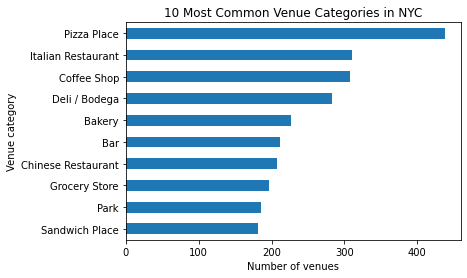

In [177]:
nyc_venues['Venue Category'].value_counts(normalize=False,ascending=False).head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('10 Most Common Venue Categories in NYC')
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

###### 10 Most Common Venue Categories in Toronto

In [234]:
# from importlib import reload
# plt=reload(plt)

Text(0, 0.5, 'Venue category')

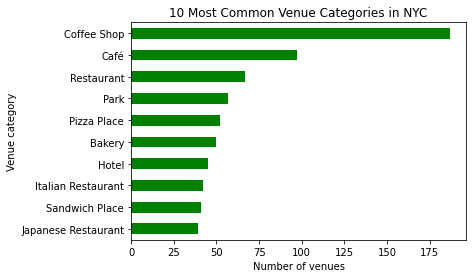

In [176]:
tor_venues['Venue Category'].value_counts(normalize=False,ascending=False).head(10).plot(kind='barh',color='green')
plt.gca().invert_yaxis()
plt.title('10 Most Common Venue Categories in NYC')
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

###### Which Venue Categories Exist in More NYC Neighborhoods?

305 neighborhoods in NYC


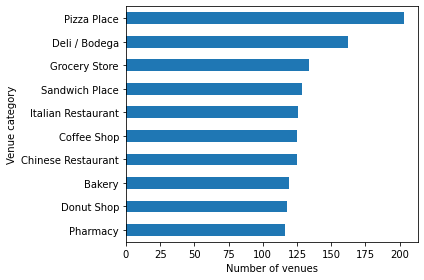

In [235]:
nyc_g = ny_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
nyc_p.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')
plt.tight_layout()

###### Which Venue Categories Exist more in Toronto Neighborhoods?

98 neighborhoods in NYC


Text(-45.875, 0.5, 'Venue category')

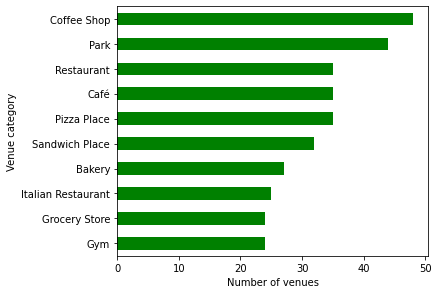

In [236]:
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(tor_g.shape[0]))
tor_p.head(10).plot(kind='barh', color='green')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlabel('Number of venues')
plt.ylabel('Venue category')

###### Rare Categories in New York City

In [180]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(10).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

,Count
Venue Category,
Nightlife Spot,1
Dosa Place,1
Tech Startup,1
Pakistani Restaurant,1
Eye Doctor,1
Arcade,1
Duty-free Shop,1
Gluten-free Restaurant,1
Venezuelan Restaurant,1


###### Rare Categories in Torronto

In [181]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

,Count
Venue Category,
Health & Beauty Service,1
Korean BBQ Restaurant,1
Wings Joint,1
Tennis Court,1
Molecular Gastronomy Restaurant,1
Swim School,1
Airport Gate,1
Afghan Restaurant,1
Candy Store,1


###### Grouping Toronto and New York data into one Dataframe. We will then use this dataframe for further insightes.

In [184]:
clmns_nyc_only = set(ny_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(ny_grouped.columns))

nyc_grouped_ = ny_grouped.copy()
nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [189]:
print(nyc_tor_grouped.shape)
nyc_tor_grouped.loc[300:310,]

(403, 476)


,Neighborhood_,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,ATM,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,...,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Truck Stop,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
300,Woodhaven_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047619,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.095238,0.047619,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
301,Woodlawn_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.000000,0.037037,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.037037,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
302,Woodrow_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.052632,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
303,Woodside_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036585,0.0,0.0,0.0,0.012195,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.048780,0.012195,0.036585,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.060976,0.0,0.0,0.0,0.0,0.012195,0.012195,0.0,0.0,0.0,0.000000,0.0,0.000000,0.012195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
304,Yorkville_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.000000,0.010000,0.050000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.020000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.01,0.0,0.0,0.0
305,Agincourt_Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0
306,"Alderwood , Long Branch_Toronto",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,

In [199]:

# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], 5)

nyc_tor_neighborhoods_categories_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton_NYC,Pizza Place,Deli / Bodega,Supermarket,Pharmacy,Discount Store
1,Annadale_NYC,Pizza Place,Pub,Restaurant,Food,Pharmacy
2,Arden Heights_NYC,Pizza Place,Pharmacy,Coffee Shop,Pool,Yoga Studio
3,Arlington_NYC,Bus Stop,Intersection,Boat or Ferry,Coffee Shop,Grocery Store
4,Arrochar_NYC,Pizza Place,Italian Restaurant,Deli / Bodega,Bus Stop,Liquor Store


In [200]:
nyc_tor_neighborhoods_categories_sorted.shape

(403, 6)

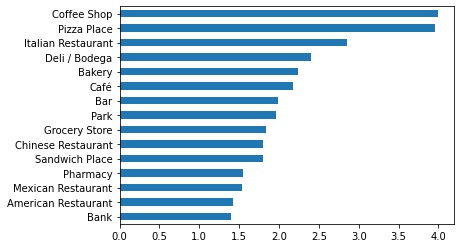

In [203]:
nyc_tor_top_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=True) * 100
nyc_tor_top_vc.head(15).plot(kind='barh')
plt.gca().invert_yaxis()

#### Clustering

In [204]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 3, 3, 2, 3, 3], dtype=int32)

In [205]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood')

nyc_tor_merged.iloc[300:310]

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,
Woodhaven_NYC,2,Deli / Bodega,Bank,Pharmacy,Restaurant,Fried Chicken Joint
Woodlawn_NYC,2,Pizza Place,Deli / Bodega,Pub,Playground,Bakery
Woodrow_NYC,2,Pharmacy,Home Service,Chinese Restaurant,Donut Shop,Gift Shop
Woodside_NYC,3,Grocery Store,Thai Restaurant,Bakery,Latin American Restaurant,Filipino Restaurant
Yorkville_NYC,3,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega
Agincourt_Toronto,3,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Food Court
"Alderwood , Long Branch_Toronto",2,Pizza Place,Pub,Gym,Pharmacy,Coffee Shop
"Bathurst Manor , Wilson Heights , Downsview North_Toronto",2,Coffee Shop,Bank,Sushi Restaurant,Fried Chicken Joint,Gas Station
Bayview Village_Toronto,2,Chinese Restaurant,Bank,Japanese Restaurant,Café,Fast Food Restaurant


In [209]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]

#### Comparing New York and Toronto venues in each cluster

In [215]:
n_counts = []
clusters = [c1, c2, c3, c4, c5]
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))


ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

print(city_c_df.shape)
city_c_df.head()

(5, 2)


,NYC,Toronto
cluster 1,2,3
cluster 2,3,10
cluster 3,171,18
cluster 4,129,66
cluster 5,0,1


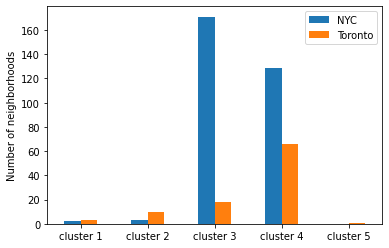

In [243]:
city_c_df.plot(kind='bar',rot=0)
plt.ylabel('Number of neighborhoods')
plt.show()